In [1]:
#!pip3 install xgboost imblearn sklearn pickle pandas matplotlib seaborn

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from dateutil import parser
import os
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from data_preprocessing_v2 import Data_Preprocessing
from model_v2 import model_fit, model_blending, feature_importance
from model_v2 import model_inference
import datetime
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [31]:
def validate_dirs(dir):
    try: 
        if not os.path.exists(dir):
            os.makedirs(dir)  
    except OSError:
        print('Error: Creating directory to store person')

In [32]:
validate_dirs("models")
validate_dirs("result")
validate_dirs("cm")

In [33]:
train_df = pd.read_csv('train/train.csv')
test_df= pd.read_csv('test/test.csv')

In [34]:
# Reading the dataframe
train_df.head(n=2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


In [35]:
# checking for the null values
train_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [36]:
# Checking for any duplicate rows 
train_df.duplicated().sum()

0

In [37]:
# looking at the unique values of the dataframe features for identifying possible categorical
# and numerical feautures 

unique_values = []
for i in range(len(train_df.columns)):
    unique_values.append([train_df.columns[i],train_df.iloc[:,i].nunique(),train_df.iloc[:,i].dtypes])


unique_values = pd.DataFrame(unique_values)
unique_values.columns = ['Column name', 'Unique_values','Dtypes']
#unique_values['datatype'] =unique_values[i].dtypes
print(unique_values)

             Column name  Unique_values   Dtypes
0                     id         381109    int64
1                 Gender              2   object
2                    Age             66    int64
3        Driving_License              2    int64
4            Region_Code             53  float64
5     Previously_Insured              2    int64
6            Vehicle_Age              3   object
7         Vehicle_Damage              2   object
8         Annual_Premium          48838  float64
9   Policy_Sales_Channel            155  float64
10               Vintage            290    int64
11              Response              2    int64


In [10]:
# Looking at the statistics 
train_df.describe0

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [11]:
data_processor  = Data_Preprocessing()
train_drop_colums = ['Response','id']
test_drop_colums = ['id']
label_column = 'Response'
key = 'id'
custom_encode_col = "Vehicle_Age"
X, Y = data_processor.data_processing_pipeline(train_df, train_drop_colums , label_column, key, data_type = 'Train', custom_encode_col=custom_encode_col) 


X_test = data_processor.data_processing_pipeline(test_df, test_drop_colums , label_column, key, data_type = 'Test', custom_encode_col=custom_encode_col) 

Categorical_Columns ::  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Numerical_Columns ::  Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')
 
## :: Train :: ##
CATEGORICAL COLUMN ENCODED ::  Gender
CATEGORICAL COLUMN ENCODED ::  Vehicle_Age
CATEGORICAL COLUMN ENCODED ::  Vehicle_Damage

:: Pandas correlation : Categorical VS Numerical :: 


,Gender,Vehicle_Age,Vehicle_Damage,id
id,0.000999,-0.001345,-0.001507,1.000000
Age,0.145545,-0.522300,0.267534,0.001561
Driving_License,-0.018374,0.030173,-0.016622,-0.000564
Region_Code,0.000604,-0.027840,0.028235,-0.000572
Previously_Insured,-0.081932,0.174783,-0.824143,0.002457
Annual_Premium,0.003673,0.023656,0.009349,0.003027
Policy_Sales_Channel,-0.111159,0.388551,-0.224377,-0.002837
Vintage,-0.002517,0.002484,-0.002064,-0.000630
Response,0.052440,-0.104078,0.354400,-0.001368



:: Pandas correlation : Categorical VS Categorical :: 


,Gender,Vehicle_Age,Vehicle_Damage,id
Gender,1.000000,-0.112625,0.091606,0.000999
Vehicle_Age,-0.112625,1.000000,-0.174238,-0.001345
Vehicle_Damage,0.091606,-0.174238,1.000000,-0.001507
id,0.000999,-0.001345,-0.001507,1.000000


381109
Categorical_Columns ::  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Numerical_Columns ::  Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')
 
## :: Test :: ##
CATEGORICAL COLUMN ENCODED ::  Gender
CATEGORICAL COLUMN ENCODED ::  Vehicle_Age
CATEGORICAL COLUMN ENCODED ::  Vehicle_Damage

:: Pandas correlation : Categorical VS Numerical :: 


,Gender,Vehicle_Age,Vehicle_Damage,id
id,0.000576,0.002350,0.000988,1.000000
Age,0.149650,-0.524189,0.270706,-0.005364
Driving_License,-0.015621,0.029533,-0.013101,-0.003581
Region_Code,0.000952,-0.026971,0.024151,-0.001574
Previously_Insured,-0.085088,0.177841,-0.823464,-0.000281
Annual_Premium,0.002968,0.023207,0.009968,0.001386
Policy_Sales_Channel,-0.112806,0.389822,-0.230298,0.002911
Vintage,-0.000842,0.000312,0.001879,0.001225



:: Pandas correlation : Categorical VS Categorical :: 


,Gender,Vehicle_Age,Vehicle_Damage,id
Gender,1.000000,-0.115935,0.094250,0.000576
Vehicle_Age,-0.115935,1.000000,-0.177244,0.002350
Vehicle_Damage,0.094250,-0.177244,1.000000,0.000988
id,0.000576,0.002350,0.000988,1.000000


127037


In [12]:
X.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender,Vehicle_Age,Vehicle_Damage
0,44,1,28.0,0,40454.0,26.0,217,1,2,1
1,76,1,3.0,0,33536.0,26.0,183,1,0,0
2,47,1,28.0,0,38294.0,26.0,27,1,2,1
3,21,1,11.0,1,28619.0,152.0,203,1,1,0
4,29,1,41.0,1,27496.0,152.0,39,0,1,0


In [13]:
df = X.copy()
df["Target"] = Y

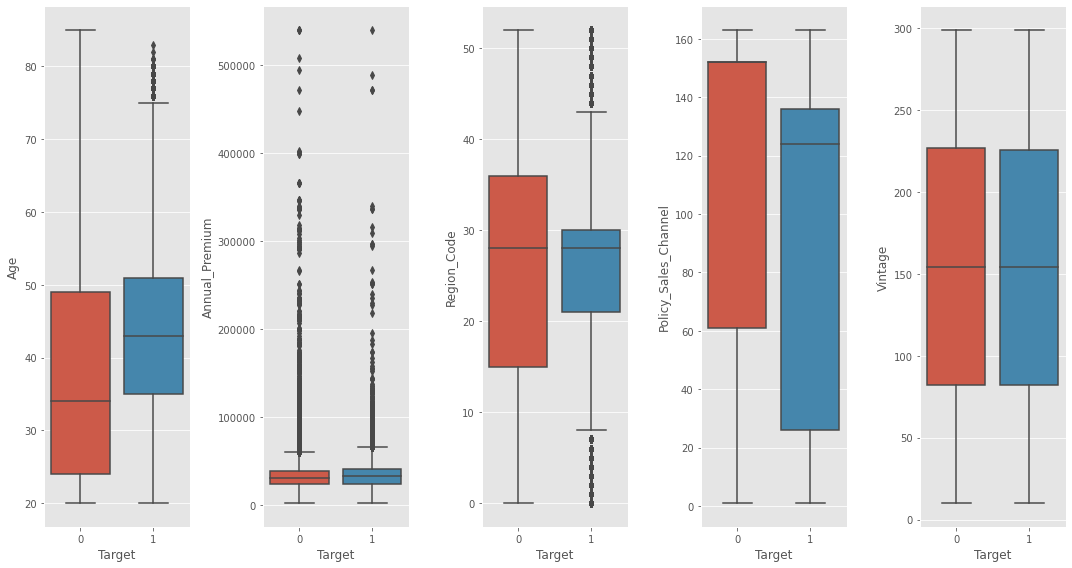

In [14]:
plt.rcParams['figure.figsize']=(15,8)
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)


sns.boxplot('Target',y='Age',data=df, ax=ax1)
sns.boxplot('Target',y='Annual_Premium',data=df, ax=ax2)
sns.boxplot('Target',y='Region_Code',data=df, ax=ax3)
sns.boxplot('Target',y='Policy_Sales_Channel',data=df, ax=ax4)
sns.boxplot('Target',y='Vintage',data=df, ax=ax5)


f.tight_layout()

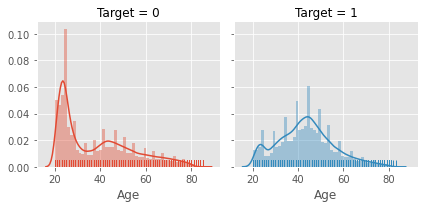

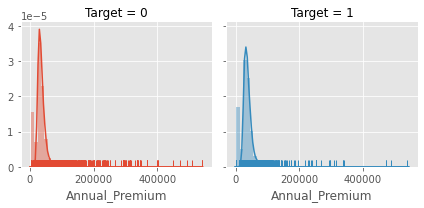

In [15]:
col = "Target"
hue = "Target"
plt.rcParams['figure.figsize']=(15,8)
g = sns.FacetGrid(df, col= col, hue=hue)
g.map(sns.distplot, df.columns[0], hist=True, rug=True)

g = sns.FacetGrid(df, col= col, hue=hue)
g.map(sns.distplot, df.columns[4], hist=True, rug=True)

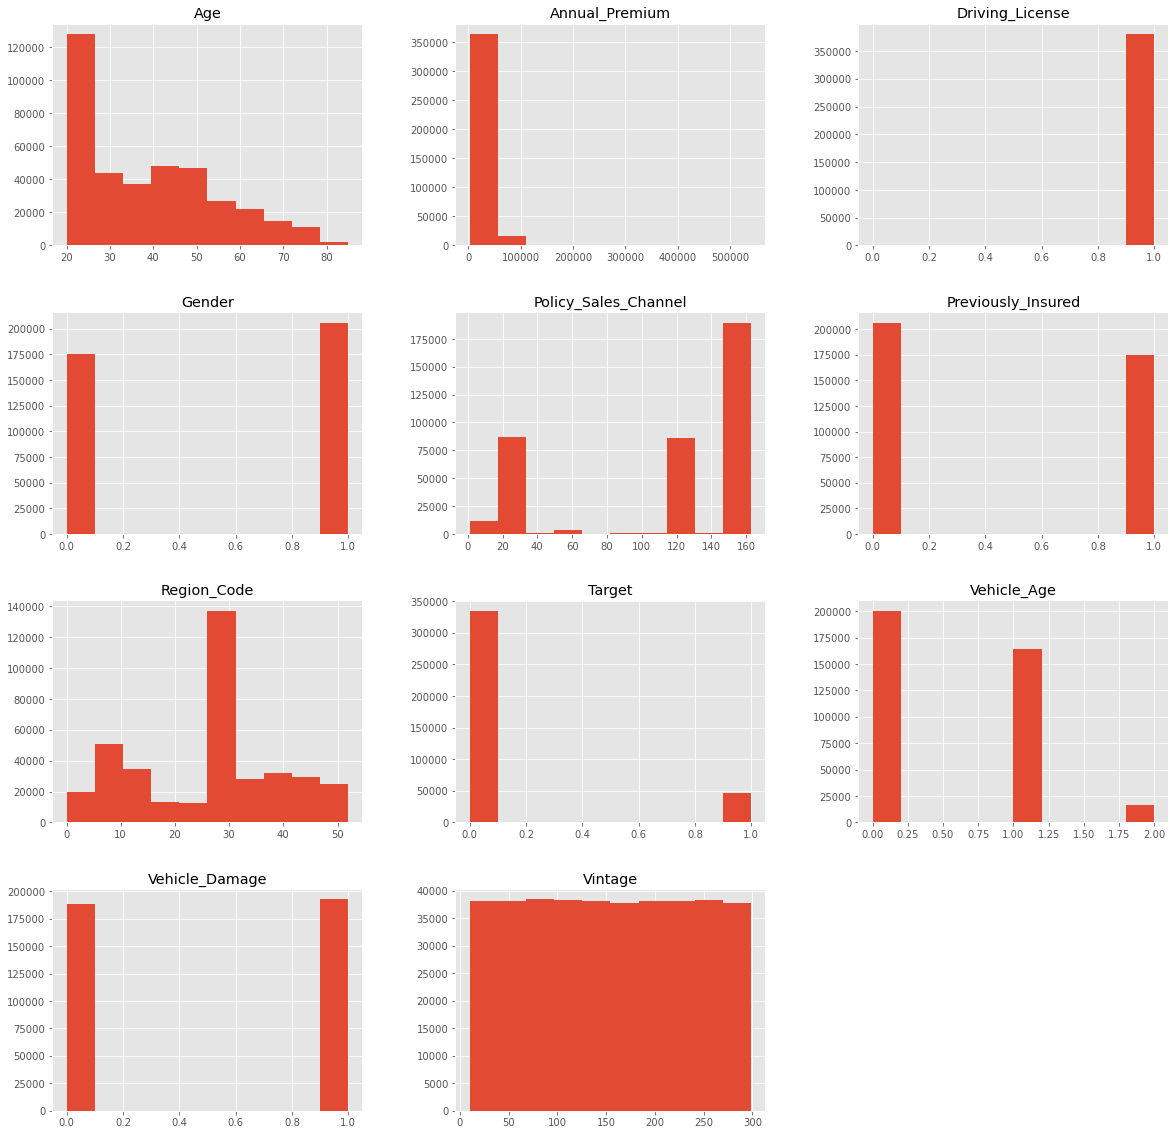

In [16]:
df.hist(figsize = (20, 20))
plt.show()

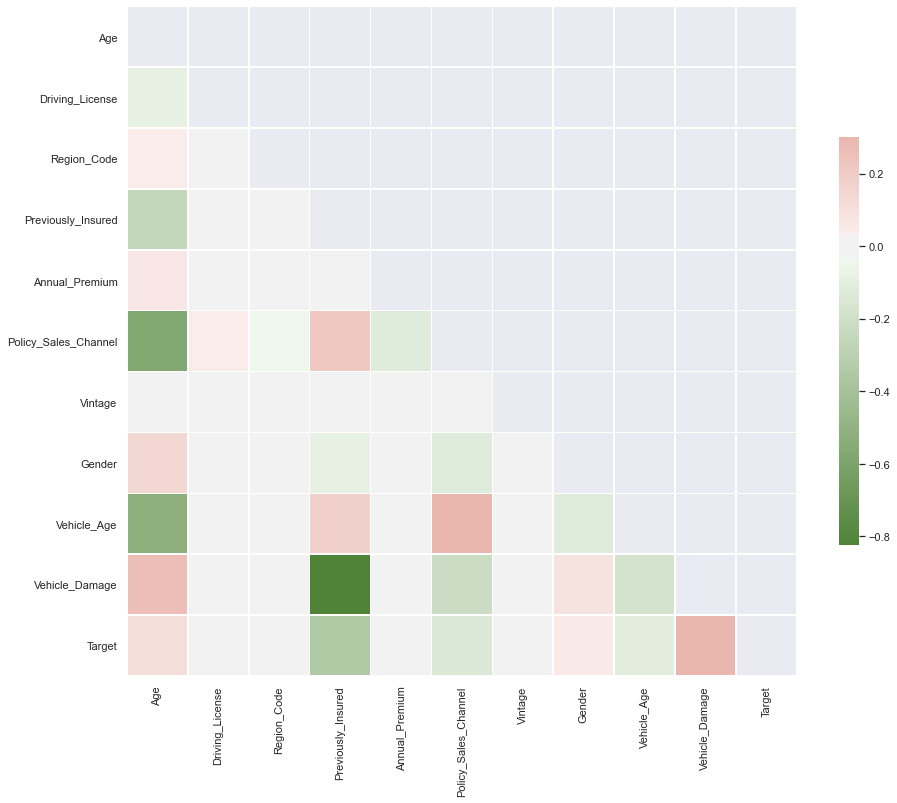

In [17]:
## Correlation Matrix
sns.set(style="dark")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(120, 17, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# XGBoost, CatBoost and LGB
* `KFold`
* `StratifiedShuffleSplit`
* `stratifiedKFold`


In [18]:
def save_result(result, file_name):
    df_sub = pd.read_csv('sample_submission.csv')
    df_sub.head()
    df_xgb = df_sub.copy()
    df_xgb['Response'] = result
    df_xgb.head()
    df_xgb.to_csv('result/'+ filename +'.csv', index=False )

In [19]:
%%capture
# model---> xgboost 
split_type = "stratifiedsuffleSplit" # stratifiedsuffleSplit, stratifiedKFold, kfold
model_name_xgb = "xgboost"
probs_xgb, probs_xgb_train, model = model_fit(X, Y, X_test, 5, split_type, model_name_xgb)

[0.01215119 0.00249397 0.00336308 0.56809044 0.00225308 0.01071135
 0.00156605 0.0019503  0.02473354 0.372687  ]


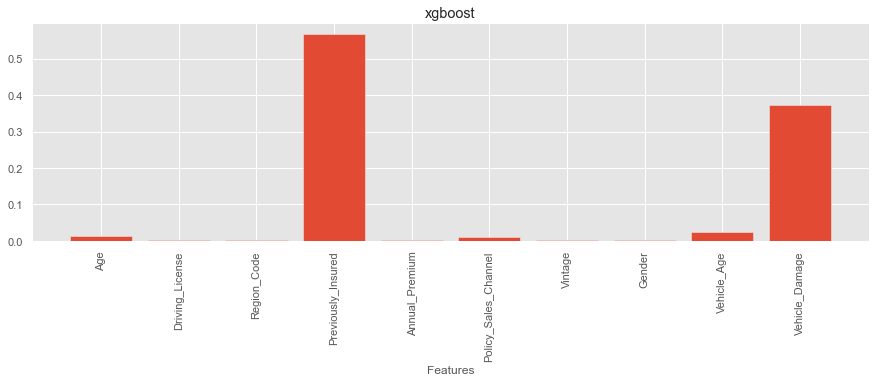

In [20]:
# Feature Importance 
plt.style.use('ggplot')
plt.subplots(figsize=(15, 4))
feature_importance(model, X, model_name_xgb)

In [21]:
%%capture
# model---> catboost 
split_type = "stratifiedsuffleSplit" # stratifiedsuffleSplit, stratifiedKFold, kfold
model_name_cb = "catboost"
probs_cb, probs_cb_train, model = model_fit(X, Y, X_test, 5, split_type, model_name_cb )

[11.74401911  0.07870499  8.92832467 44.53736221  4.93055906  9.24529416
  3.42795647  2.11910277  2.89352468 12.09515188]


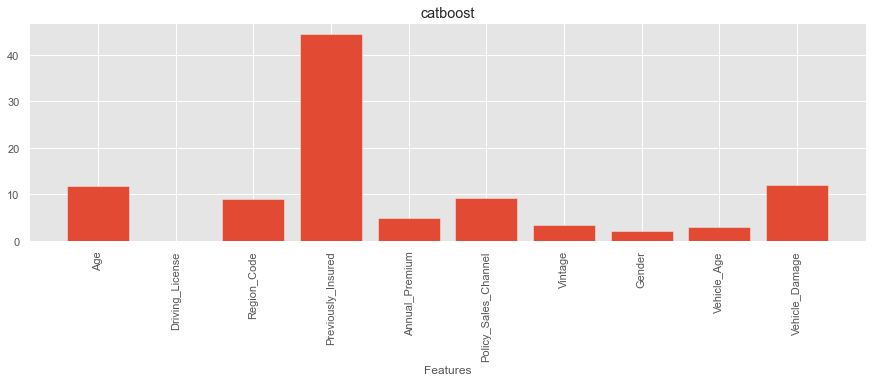

In [22]:
# Feature Importance
fig, ax = plt.subplots(figsize=(15, 4))
feature_importance(model, X, model_name_cb)

In [23]:
%%capture
# model---> lgb 
split_type = "stratifiedsuffleSplit" # stratifiedsuffleSplit, stratifiedKFold, kfold
model_name_lgb = "lgb"
probs_lgb, probs_lgb_train, model = model_fit(X, Y, X_test, 5, split_type, model_name_lgb)


[106465.35203448   2238.21583518  32855.06841219 568826.65530017
  15651.34429674 219939.6456392   10652.63471374   2472.5566217
  61684.41158557 582721.2123104 ]


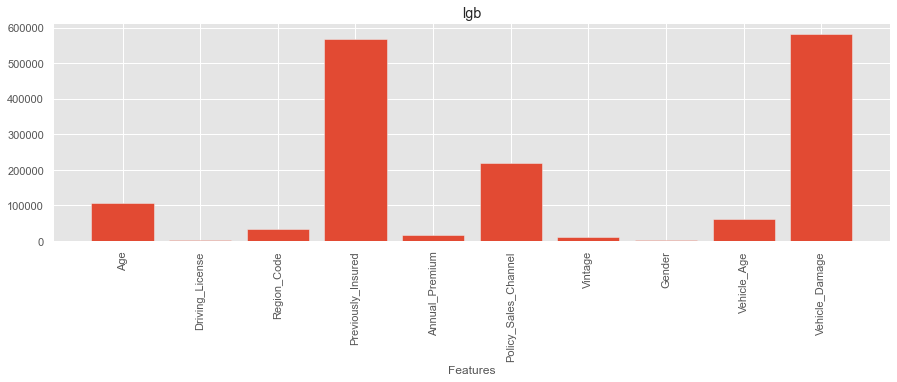

In [24]:
# Feature Importance
fig, ax = plt.subplots(figsize=(15, 4))
feature_importance(model, X, model_name_lgb)

In [25]:
# Test set predict_probs
p_cb = probs_cb/5
p_xgb = probs_xgb/5 
# Train Set Predict_probs 
p_cb_train = probs_cb_train/5
p_xgb_train = probs_xgb_train/5 

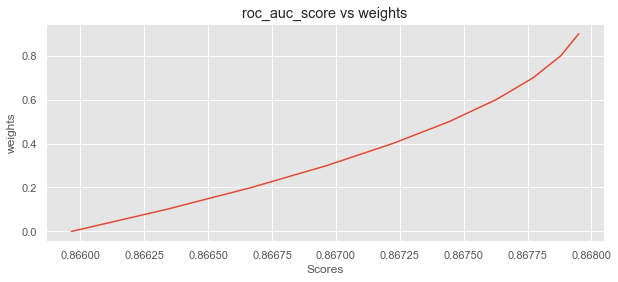

0.9

0.8679501680974352

In [26]:
from model_v2 import model_blending as blend
from sklearn.metrics import roc_auc_score,confusion_matrix
plt.subplots(figsize=(10, 4))
best_w, best_roc = blend(p_xgb_train, p_cb_train, Y)
display(best_w)
display(best_roc)

In [28]:
w = best_w
result = w * p_xgb + (1-w) * p_cb
#filename = "model_blending_cb_xgb_"+split_type+"_best_w-" + str(w) + "-"+ datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
#save_result(result, filename)

In [29]:
w = 0.5
result = w * p_xgb + (1-w) * p_cb
#filename = "model_blending_cb_xgb_"+split_type+"_best_w-" + str(w) + "-"+ datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
#save_result(result, filename)

# Model Load and Predict, predict_proba

def model_predict(X,model_prefix, prediction=None, predict_probs=None):  
    import pickle, joblib
    import glob
    pridict = np.zeros(shape=(len(X),))
    models_path = glob.glob(model_prefix)
    for i, v in enumerate(models_path):
        model = joblib.load(v)
        if prediction:
            result = model.predict(X)
        if predict_probs:
            result = model.predict_proba(X)    
        pridict += result
    return pridict    


# Confusion Matrix

# Xgboost
model_path_prefix_xgb = "models/" + model_name_xgb + "/" + split_type + "/" + model_name_xgb +"_" + split_type + "*"
y_pred_xgb = (model_predict(X, model_path_prefix_xgb, prediction=True, predict_probs=False)/5).astype(int) 
cm_xgb = confusion_matrix(Y, y_pred_xgb)
cm_df_xgb = pd.DataFrame(data=cm_xgb, columns=["Response_0", "Response_1"], index=["Response_0", "Response_1"])
cm_df_xgb.to_csv("cm/xgb_cm_" + split_type + ".csv")
print("::SAVED XGB CONFUSION MATRIX::")

#catboost
model_path_prefix_cb = "models/" + model_name_cb + "/" + split_type + "/" + model_name_cb +"_" + split_type + "*"
y_pred_cb = (model_predict(X, model_path_prefix_cb, prediction=True, predict_probs=False)/5).astype(int)
cm_cb = confusion_matrix(Y, y_pred_cb)
cm_df_cb = pd.DataFrame(data=cm_cb, columns=["Response_0", "Response_1"], index=["Response_0", "Response_1"])
cm_df_cb.to_csv("cm/catboost_cm_" + split_type + ".csv")
print("::SAVED CATBOOST CONFUSION MATRIX::")

#LightGB
model_path_prefix_lgb = "models/" + model_name_lgb + "/" + split_type + "/" + model_name_lgb +"_" + split_type + "*"
y_pred_cb = (model_predict(X, model_path_prefix_lgb, prediction=True, predict_probs=False)/5).astype(int)
cm_cb = confusion_matrix(Y, y_pred_lgb)
cm_df_cb = pd.DataFrame(data=cm_cb, columns=["Response_0", "Response_1"], index=["Response_0", "Response_1"])
cm_df_cb.to_csv("cm/" + model_name_lgb + "_cm_" + split_type + ".csv")
print("::SAVED LGB CONFUSION MATRIX::")